# Implementing tile overlap

The example that this process is based off is only 2D image. 

I have a 4D stack so I need to separate each layer and tile individually.

Now tiling over time and z stack, but testing to see if order of iteration matters. 

In [1]:
import glob
import os
import enum
import re
import dask
import dask.array as da
from dask.array.core import normalize_chunks
# from dask_image.imread import imread ### this way seems quicker
import skimage
from skimage.io import imshow, imread
import numpy as np
from tqdm.auto import tqdm
import napari
import matplotlib.pyplot as plt
import pandas as pd
import xml.etree.ElementTree as ET
from skimage.transform import AffineTransform
from typing import Tuple, List, Dict, Union, Optional, Callable 
from pathlib import Path
from functools import partial
from scipy.ndimage import affine_transform

from shapely.geometry.base import BaseGeometry
from shapely.geometry.polygon import Polygon
from shapely.geometry import LineString
from shapely.strtree import STRtree

In [2]:
@enum.unique
class Channels(enum.Enum):
    BRIGHTFIELD = 0
    GFP = 1
    RFP = 2
    IRFP = 3
    MASK_2 = 97
    MASK_1 = 98
    MASK = 99

def parse_filename(filename: os.PathLike) -> dict:
    """Parse an OctopusHeavy filename and retreive metadata from the file.

    Parameters
    ----------
    filename : PathLike
        The full path to a file to parse.

    Returns
    -------
    metadata : dict
        A dictionary containing the parsed metadata.
    """
    
    OCTOPUSHEAVY_FILEPATTERN =(
        "r(?P<row>[0-9]+)c(?P<column>[0-9]+)f(?P<mosaic_pos>[0-9]+)p(?P<plane>[0-9]+)-ch(?P<channel>[0-9]+)"
        "sk(?P<time>[0-9]+)fk(?P<fk>[0-9]+)fl(?P<fl>[0-9]+)"
        )
    
    path, filename = os.path.split(filename)
    params = re.match(OCTOPUSHEAVY_FILEPATTERN, filename)

    filename_metadata = {
        "filename": filename,
        "channel": params.group("channel"),# Channels(int(params.group("channel"))),
        "time": params.group("time"),
        "row": params.group("row"), 
        "column": params.group("column"), 
        "mosaic_pos": params.group("mosaic_pos"), 
        "plane": params.group("plane"), 
        "fk": params.group("fk"), 
        "fl": params.group("fl")

    }

    return filename_metadata

def read_harmony_metadata(metadata_path: os.PathLike):
    """
    Read the metadata from the Harmony software for the Opera Phenix microscope.
    Takes an input of the path to the metadata .xml file.
    Returns the metadata in a pandas dataframe format.
    """
    
    ### read xml metadata file
    xml_data = open(metadata_fn, 'r').read()
    root = ET.XML(xml_data) 
    ### extract the metadata from the xml file
    images_metadata = [child for child in root if "Images" in child.tag][0]
    ### create an empty list for storing individual image metadata
    all_images_dicts = list()
    ### iterate over every image entry extracting the metadata
    for image_metadata in tqdm(images_metadata, total = len(images_metadata)):
        ### create empty dict to store single image metadata
        single_image_dict = dict()
        ### iterate over every metadata item in that image metadata
        for item in image_metadata:
            ### get column names from metadata
            col = item.tag.replace('{http://www.perkinelmer.com/PEHH/HarmonyV5}','')
            ### get metadata
            entry = item.text
            ### make dictionary out of metadata
            single_image_dict[col] = entry
        ### append that image metadata to list of all images    
        all_images_dicts.append(single_image_dict)
    ### create a dataframe out of all metadata
    df = pd.DataFrame(all_images_dicts)
    
    return df

In [302]:
def transform_tile_coord(shape: Tuple[int,int], affine_matrix: np.ndarray) -> np.ndarray:
    """
    returns the corner coordinates of a 2D array with shape shape
    after applying the transform represented by affine_matrix.
    From DaskFusion (https://github.com/VolkerH/DaskFusion/)
    """
    h, w = shape
    # create homogeneous coordinates for corner points
    baserect = np.array([[0, 0], [h, 0], [h, w], [0, w]])
    augmented_baserect = np.concatenate(
        (baserect, np.ones((baserect.shape[0], 1))), axis=1
    )
    # see where the corner points map to
    transformed_rect = (affine_matrix @ augmented_baserect.T).T[:, :-1]
    return transformed_rect

def get_chunk_coord(shape: Tuple[int, int], chunk_size: Tuple[int, int]):
    """Iterator that returns the bounding coordinates
    for the individual chunks of a dask array of size
    shape with chunk size chunk_size.


    return_np_slice determines the output format. If True,
    a numpy slice object is returned for each chunk, that can be used
    directly to slice a dask array to return the desired chunk region.
    If False, a Tuple of Tuples ((row_min, row_max+1),(col_min, col_max+1))
    is returned.
    From DaskFusion (https://github.com/VolkerH/DaskFusion/)

    """
    chunksy, chunksx = normalize_chunks(chunk_size, shape=shape)
    y = 0
    for cy in chunksy:
        x = 0
        for cx in chunksx:
            yield ((y, y + cy), (x, x + cx))
            x = x + cx
        y = y + cy
        
def numpy_shape_to_shapely(coords: np.ndarray, shape_type: str = "polygon") -> BaseGeometry:
    """
    Convert an individual shape represented as a numpy array of coordinates
    to a shapely object
    From DaskFusion (https://github.com/VolkerH/DaskFusion/)
    """
    _coords = coords[:, ::-1].copy()  # shapely has col,row order, numpy row,col
    _coords[:, 1] *= -1  # axis direction flipped between shapely and napari
    if shape_type in ("rectangle", "polygon", "ellipse"):
        return Polygon(_coords)
    elif shape_type in ("line", "path"):
        return LineString(_coords)
    else:
        raise ValueError
        
def get_rect_from_chunk_boundary(chunk_boundary):
    """given a chunk boundary tuple, return a numpy
    array that can be added as a shape to napari"
    From DaskFusion (https://github.com/VolkerH/DaskFusion/)
    """
    ylim, xlim = chunk_boundary
    miny, maxy = ylim[0], ylim[1] - 1
    minx, maxx = xlim[0], xlim[1] - 1
    return np.array([[miny, minx], [maxy, minx], [maxy, maxx], [miny, maxx]])

def find_chunk_tile_intersections(
    tiles_shapely: List["shapely.geometry.base.BaseGeometry"],
    chunks_shapely: List["shapely.geometry.base.BaseGeometry"],
) -> Dict[Tuple[int, int], Tuple[str, np.ndarray]]:
    """
    For each output array chunk, find the intersecting image tiles

    Args:
        tile_shapes: Contains the shapely objects corresponding to transformed image outlines.
                    Each shape in tile_shapes must have a .fuse_info dictionary with
                    keys "file" and "transform".
        chunk_shapes: Contains the shapely objects representing dask array chunks.
                    Each shape in chunk_shapes must have a .fuse_info dictionary with
                    key "chunk_boundary", containing a tuple of chunk boundaries

    Returns:
         The chunk_to_tiles dictionary, which has the chunk anchor points as keys and tuples of
         image file names and their corresponding affine transform matrix as values.
    From DaskFusion (https://github.com/VolkerH/DaskFusion/)
    """
    chunk_to_tiles = {}
    tile_tree = STRtree(tiles_shapely)

    for chunk_shape in chunks_shapely:
        chunk_boundary = chunk_shape.fuse_info["chunk_boundary"]
        anchor_point = (chunk_boundary[0][0], chunk_boundary[1][0])
        intersecting_tiles = tile_tree.query(chunk_shape)
        chunk_to_tiles[anchor_point] = [
            ((t.fuse_info["file"], t.fuse_info["transform"]))
            for t in intersecting_tiles
        ]
    return chunk_to_tiles

def fuse_func(
    input_tile_info: Dict[
        Tuple[int, int], List[Tuple[Union[str, Path, np.ndarray], np.ndarray]]
    ],
    imload_fn: Optional[Callable] = imread,
    block_info=None,
    dtype=np.uint16,
) -> np.ndarray:

    """
    Fuses the tiles that intersect the current chunk of a dask array using maximum projection.

    Pass this function to dask.array.map_blocks, after partial evaluation of the required
    image_folder and (if needed) optional arguments.

    Returns:
        Array of chunk-shape containing max projection of tiles falling into chunk
        
    From DaskFusion (https://github.com/VolkerH/DaskFusion/)
    """
    array_location = block_info[None]["array-location"]
    # The anchor point is the key to the input_tile_info dictionary
    anchor_point = (array_location[0][0], array_location[1][0])
    chunk_shape = block_info[None]["chunk-shape"]
    tiles_info = input_tile_info[anchor_point]
    #print(f"Processing chunk at {anchor_point}")
    fused = np.zeros(chunk_shape, dtype=dtype)
    for image_representation, tile_affine in tiles_info:
        if imload_fn is not None:
            # When imload_fn is provided we assume we have been given strings representing files
            tile_path = image_representation
            im = imload_fn(tile_path)
        else:
            # Without imload function we assume images are passed
            im = image_representation
        shift = AffineTransform(translation=(-anchor_point[0], -anchor_point[1]))
        tile_shifted = affine_transform(
            im,
            matrix=np.linalg.inv(shift.params @ tile_affine),
            output_shape=chunk_shape,
            cval=0,
        )
        # note that the dtype comversion here happens without scaling
        # may want to use one of the skimage.img_as_* functions instead
        stack = np.stack([fused, tile_shifted.astype(dtype)])
        fused = np.max(stack, axis=0)
    return fused

FilePath = Union[Path, str]
ArrayLike = Union[
    np.ndarray, "dask.array.Array"
]  # could add other array types if needed


def load_image(
    file: FilePath, transforms: List[Callable[[ArrayLike], ArrayLike]] = None
) -> np.ndarray:
    img = imread(file)
    # if img.ndim == 2:
    #    img = np.expand_dims(img, axis=0)
    if transforms is not None:
        for t in transforms:
            img = t(img)
    return img

def stitch(time, plane, channel, row, col, chunk_fraction):
    ### extract metadata for this mosaic
    filtered_df = df[(df['TimepointID'] == time)  
                   &(df['PlaneID'] == plane)
                   &(df['ChannelID'] == channel)
                   &(df['Row'] == row) 
                   &(df['Col'] == col)
                    ]
    ### extract filenames for subset
    fns = filtered_df['URL']
    ### build into full file path
    fns = [glob.glob(os.path.join(image_dir, fn))[0] for fn in fns]
    ### stack single slice mosaic into lazy array
    sample = skimage.io.imread(fns[0])
    lazy_arrays = [dask.delayed(skimage.io.imread)(fn) for fn in fns]
    lazy_arrays = [da.from_delayed(x, shape=sample.shape, dtype=sample.dtype)#'uint8')#
                   for x in lazy_arrays]
    #print(len(lazy_arrays), 'images lazily loaded')
    ### extract and convert coordinates from standard units into pixels
    coords = filtered_df[["URL", "PositionX", "PositionY", "PositionZ", "ImageResolutionX", "ImageResolutionY"]]
    coords['PositionXPix'] = (coords['PositionX'].astype(float))/(coords['ImageResolutionX']).astype(float)
    coords['PositionYPix'] = (coords['PositionY'].astype(float))/(coords['ImageResolutionY']).astype(float)
    norm_coords = list(zip(coords['PositionXPix'], coords['PositionYPix']))
    ### convert tile coordinates into transformation matrices
    transforms = [AffineTransform(translation=stage_coord).params for stage_coord in norm_coords]
    tiles = [transform_tile_coord(sample.shape, transform) for transform in transforms]
    ### shift the tile coordinates to the origin
    all_bboxes = np.vstack(tiles)
    all_min = all_bboxes.min(axis=0)
    all_max = all_bboxes.max(axis=0)
    stitched_shape=tuple(np.ceil(all_max-all_min).astype(int))
    shift_to_origin = AffineTransform(translation=-all_min)
    transforms_with_shift = [t @ shift_to_origin.params for t in transforms]
    shifted_tiles = [transform_tile_coord(sample.shape, t) for t in transforms_with_shift]
    ### decide on chunk size as a fraction of total slice size 
    chunk_size = (6048/np.sqrt(chunk_fraction),6048/np.sqrt(chunk_fraction))
    chunks = normalize_chunks(chunk_size,shape=tuple(stitched_shape))
    ### check the maths adds up correctly (chunks fit into mosaic)
    computed_shape = np.array(list(map(sum, chunks)))
    assert np.all(np.array(stitched_shape) == computed_shape)
    ### get boundary coords of chunks
    chunk_boundaries = list(get_chunk_coord(stitched_shape, chunk_size))
    ### use shapely to find the intersection of the chunks
    tiles_shifted_shapely = [numpy_shape_to_shapely(s) for s in shifted_tiles]
    chunk_shapes = list(map(get_rect_from_chunk_boundary, chunk_boundaries))
    chunks_shapely = [numpy_shape_to_shapely(c) for c in chunk_shapes]
    ### build dictionary of chunk shape data with filenames and transformations
    for tile_shifted_shapely, file, transform in zip(tiles_shifted_shapely, 
                                         fns, 
                                         transforms_with_shift):
        tile_shifted_shapely.fuse_info = {'file':file, 
                                          'transform':transform}
    for chunk_shapely, chunk_boundary in zip(chunks_shapely, 
                                              chunk_boundaries):
        chunk_shapely.fuse_info = {'chunk_boundary': chunk_boundary}
    chunk_tiles = find_chunk_tile_intersections(tiles_shifted_shapely, chunks_shapely)
    ### tile images together                
    frame = da.map_blocks(func=_fuse_func,
             chunks=chunks, 
             input_tile_info=chunk_tiles,
             dtype=sample.dtype)
    
    return frame, chunk_tiles, tiles_shifted_shapely, chunks_shapely, chunk_boundaries

#### Find images

In [4]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
# image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/r03c03f01p01/'
fns = glob.glob(os.path.join(image_dir, '*.tiff'))
# fns = glob.glob(os.path.join(image_dir, f'r0{row}c0{col}*.tiff'))
print(len(fns), 'image files found')

113400 image files found


### Loading metadata

In [5]:
metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
df = read_harmony_metadata(metadata_fn)

  0%|          | 0/113400 [00:00<?, ?it/s]

In [501]:
df

,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


In [502]:
images[(3, 4)]

dask.array<stack, shape=(5, 2, 3, 6048, 6048), dtype=uint16, chunksize=(1, 1, 1, 2016, 2016), chunktype=numpy.ndarray>

#### Get position information from metadata

In [6]:
row_col_list = list()
for index, row in tqdm(df.iterrows(), total = len(df)):
    row_col_list.append(tuple((int(row['Row']), int(row['Col']))))
row_col_list = list(set(row_col_list))
for n, i in enumerate(row_col_list):
    print('Position index and (row,column):', n, i)

  0%|          | 0/113400 [00:00<?, ?it/s]

Position index and (row,column): 0 (3, 4)
Position index and (row,column): 1 (4, 3)
Position index and (row,column): 2 (4, 9)
Position index and (row,column): 3 (3, 7)
Position index and (row,column): 4 (5, 4)
Position index and (row,column): 5 (4, 6)
Position index and (row,column): 6 (3, 10)
Position index and (row,column): 7 (5, 7)
Position index and (row,column): 8 (6, 5)
Position index and (row,column): 9 (6, 8)
Position index and (row,column): 10 (4, 5)
Position index and (row,column): 11 (3, 3)
Position index and (row,column): 12 (3, 9)
Position index and (row,column): 13 (5, 6)
Position index and (row,column): 14 (4, 8)
Position index and (row,column): 15 (3, 6)
Position index and (row,column): 16 (5, 9)
Position index and (row,column): 17 (6, 4)
Position index and (row,column): 18 (6, 7)
Position index and (row,column): 19 (4, 7)
Position index and (row,column): 20 (3, 5)
Position index and (row,column): 21 (4, 4)
Position index and (row,column): 22 (4, 10)
Position index and 

## Get dimensionality of image volume

In [87]:
channel_IDs = df['ChannelID'].unique()
plane_IDs = df['PlaneID'].unique()
timepoint_IDs = df['TimepointID'].unique()

## Set mosaic parameters

The `chunk_fraction` is how many sections you want one slice cut up into (has to be a square) and the `_load_image` partial function can include any image transformations you wish (border crop or background removal etc).

In [8]:
chunk_fraction = 9
_load_image = partial(load_image, transforms=[])#input_transforms)

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
_fuse_func=partial(fuse_func, 
                   imload_fn=_load_image,
                   dtype=imread(fns[0]).dtype)

# Trying to return fn info too

how tf do I select a chunk...

In [493]:
frame, tile_info, tiles_shifted_shapely, chunks_shapely, chunk_boundaries = stitch(time, plane, channel, row, col, chunk_fraction)

In [500]:
tile_info

{(0,
  0): [('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c04f01p03-ch2sk5fk1fl1.tiff',
   array([[1.00000000e+00, 0.00000000e+00, 1.94399749e+03],
          [0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])), ('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c04f06p03-ch2sk5fk1fl1.tiff',
   array([[1.00000000e+00, 0.00000000e+00, 1.94399749e+03],
          [0.00000000e+00, 1.00000000e+00, 1.94399749e+03],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])), ('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c04f08p03-ch2sk5fk1fl1.tiff',
   array([[1., 0., 0.],
          [0., 1., 0.],
          [0., 0., 1.]])), ('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c04f07p03-ch2sk5fk1fl1.tiff',
   array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 1.00000000e+

In [497]:
chunks_shapely[0].fuse_info

{'chunk_boundary': ((0, 2016), (0, 2016))}

In [498]:
tiles_shifted_shapely

In [495]:
tiles_shifted_shapely[0].fuse_info

{'file': '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c04f01p03-ch2sk5fk1fl1.tiff',
 'transform': array([[1.00000000e+00, 0.00000000e+00, 1.94399749e+03],
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])}

In [306]:
len(chunk_boundaries)

9

In [298]:
chunks_shapely[0].bounds

(0.0, -2015.0, 2015.0, 0.0)

In [376]:
type(tiles_shifted_shapely[0])

shapely.geometry.polygon.Polygon

In [245]:
tiles_shifted_shapely[0].bounds

(0.0, -4103.997489230769, 2160.0, -1943.9974892307694)

In [267]:
tiles_shifted_shapely[0].fuse_info['transform'][0:2,2]

array([1943.99748923,    0.        ])

In [300]:
x_y = list()
for i, j in zip(chunks_shapely, tiles_shifted_shapely):
#     print(i.fuse_info['chunk_boundary'], j.fuse_info['file'])
#     print(i.bounds,'\n', j.bounds)
#     print('\n')
#     print(j.fuse_info['file'], j.fuse_info['transform'])
    print(j.fuse_info['file'], j.fuse_info['transform'][0:2,2])
    x_y.append(j.fuse_info['transform'][0:2,2])

/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c04f01p03-ch2sk5fk1fl1.tiff [1943.99748923    0.        ]
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c04f02p03-ch2sk5fk1fl1.tiff [   0.         3887.99497846]
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c04f03p03-ch2sk5fk1fl1.tiff [1943.99748923 3887.99497846]
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c04f04p03-ch2sk5fk1fl1.tiff [3887.99497846 3887.99497846]
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c04f05p03-ch2sk5fk1fl1.tiff [3887.99497846 1943.99748923]
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c04f06p03-ch2sk5fk1fl1.tiff [1943.99748923 1943.99748923]
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c04f07p03-ch2sk5fk1fl1.tiff [   0.         1943.99748923]
/mnt/DATA/sandbox/pierre_live_cell

In [276]:
import matplotlib.pyplot as plt

1943 0
0 3887
1943 3887
3887 3887
3887 1943
1943 1943
0 1943
0 0
3887 0


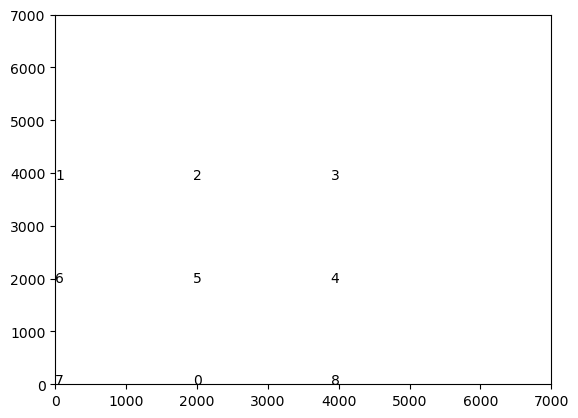

In [297]:
plt.xlim(0,7000)
plt.ylim(0,7000)
for n, i in enumerate(x_y):
    x = int(i[0])
    y = int(i[1])
    print(x, y)
    plt.text(x = x, y = y, s = n)

### How tf do I convert this to the dask array chunk selection?

Checking other params inside stitch

2951 1008
1008 4895
2951 4895
4895 4895
4895 2951
2951 2951
1008 2951
1008 1008
4895 1008


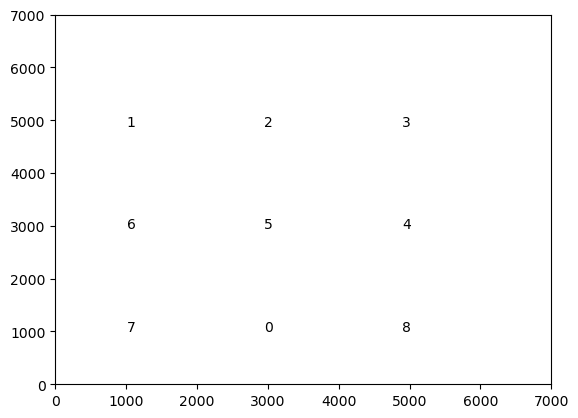

In [449]:
plt.xlim(0,7000)
plt.ylim(0,7000)
for n, i in enumerate(centrs):
    x = int(i[0])
    y = int(i[1])
    print(x, y)
    plt.text(x = x, y = y, s = n)

In [487]:
tiles_shifted_shapely

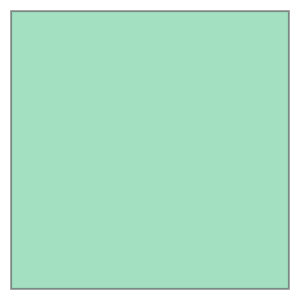

In [492]:
j

In [490]:
centrs = list()
for i, j in zip(chunks_shapely, tiles_shifted_shapely):
#     print(i.fuse_info['chunk_boundary'], j.fuse_info['file'])
#     print(i.bounds,'\n', j.bounds)
#     print('\n')
#     print(j.fuse_info['file'], j.fuse_info['transform'])
    print(j.fuse_info['file'], )#j.fuse_info['transform'][0:2,2])
    x, y = j.fuse_info['transform'][0:2,2].astype(int)
#     y, x = x, y
    crops = tuple((slice(x, x+2016), slice(y, y+2016)))
#     centrs.append((x+1008, y+1008))
    
#     crops = tuple((slice(x, y), slice(x+2016, y+2016)))
    print(crops)

/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c04f01p03-ch2sk5fk1fl1.tiff
(slice(1943, 3959, None), slice(0, 2016, None))
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c04f02p03-ch2sk5fk1fl1.tiff
(slice(0, 2016, None), slice(3887, 5903, None))
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c04f03p03-ch2sk5fk1fl1.tiff
(slice(1943, 3959, None), slice(3887, 5903, None))
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c04f04p03-ch2sk5fk1fl1.tiff
(slice(3887, 5903, None), slice(3887, 5903, None))
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c04f05p03-ch2sk5fk1fl1.tiff
(slice(3887, 5903, None), slice(1943, 3959, None))
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c04f06p03-ch2sk5fk1fl1.tiff
(slice(1943, 3959, None), slice(1943, 3959, None))
/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Repl

In [451]:
j.fuse_info['file']

'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c04f09p03-ch2sk5fk1fl1.tiff'

In [473]:
fn = j.fuse_info['file']

In [479]:
new_fn = fn.replace('ch1', 'ch99')

In [481]:
new_fn

'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c04f09p03-ch2sk5fk1fl1.tiff'

In [485]:
from skimage.io import imsave

In [486]:
help(imsave)

Help on function imsave in module skimage.io._io:

imsave(fname, arr, plugin=None, check_contrast=True, **plugin_args)
    Save an image to file.
    
    Parameters
    ----------
    fname : str or pathlib.Path
        Target filename.
    arr : ndarray of shape (M,N) or (M,N,3) or (M,N,4)
        Image data.
    plugin : str, optional
        Name of plugin to use.  By default, the different plugins are
        tried (starting with imageio) until a suitable
        candidate is found.  If not given and fname is a tiff file, the
        tifffile plugin will be used.
    check_contrast : bool, optional
        Check for low contrast and print warning (default: True).
    
    Other Parameters
    ----------------
    plugin_args : keywords
        Passed to the given plugin.
    
    Notes
    -----
    When saving a JPEG, the compression ratio may be controlled using the
    ``quality`` keyword argument which is an integer with values in [1, 100]
    where 1 is worst quality and smal

In [483]:
for i in range(10):
    print(i)
    if i ==3:
        raise Exception("Sorry, no numbers below zero") 

0
1
2
3


Exception: Sorry, no numbers below zero

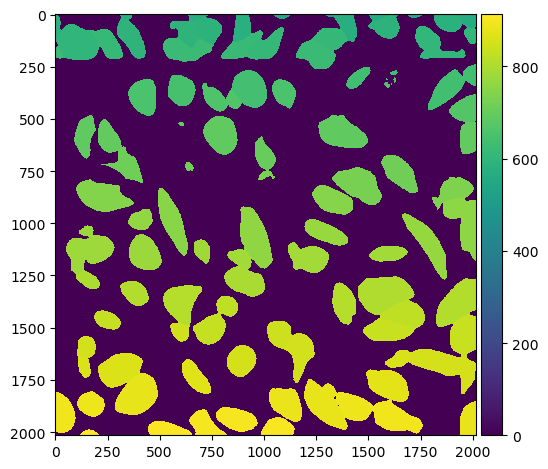

In [453]:
imshow((masks_frame)[crops])

In [452]:
crops

(slice(3887, 5903, None), slice(0, 2016, None))

this slice should be

In [455]:
6048-2016, 6048

(4032, 6048)

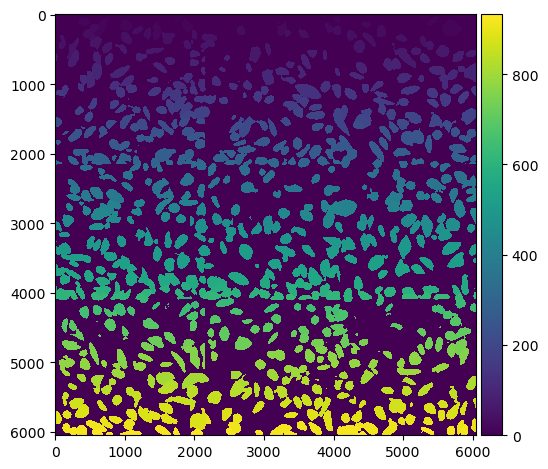

In [448]:
imshow(masks_frame)

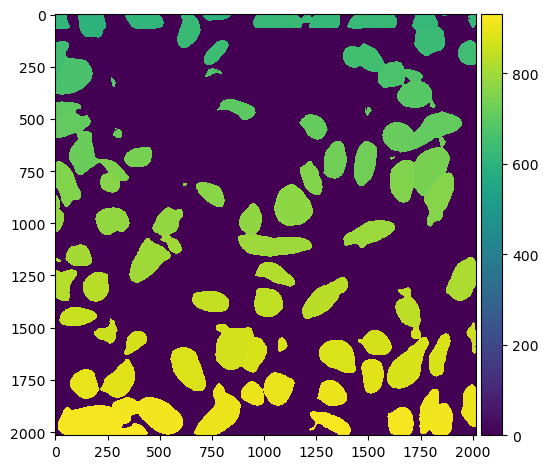

In [472]:
imshow(masks_frame[lazy_hack[9]])

In [467]:
lazy_hack = {1:(slice(4032, 6048), slice(2016, 4032)),
            2:(slice(0, 2016), slice(0, 2016)),
            3:(slice(0, 2016), slice(2016, 4032)),
            4:(slice(0, 2016), slice(4032, 6048)),
            5:(slice(2016, 4032), slice(4032, 6048)),
            6:(slice(2016, 4032), slice(2016, 4032)),
            7:(slice(2016, 4032), slice(0, 2016)),
            8:(slice(4032, 6048), slice(0, 2016)),
            9:(slice(4032, 6048), slice(4032, 6048)),
            }

In [ ]:
fov_scan_pattern = np.array(([2,3,4],
                             [7,6,5],
                             [8,1,9],))

In [456]:
slice(4032, 6048)

slice(4032, 6048, None)

In [459]:
lazy_hack[1]

(slice(4032, 6048, None), slice(2016, 4032, None))

In [373]:
masks_frame

dask.array<array, shape=(6048, 6048), dtype=uint16, chunksize=(2016, 2016), chunktype=numpy.ndarray>

In [374]:
frame

dask.array<fuse_func, shape=(6048, 6048), dtype=uint16, chunksize=(2016, 2016), chunktype=numpy.ndarray>

In [331]:
masks_frame[slice(slice_)]

TypeError: ('Invalid index type', <class 'tuple'>, ((3887.9949784615387, 5903.994978461538), (0.0, 2016.0)))

In [325]:
masks_frame[crops]

dask.array<getitem, shape=(2016, 2016), dtype=uint16, chunksize=(1871, 1871), chunktype=numpy.ndarray>

In [307]:
chunk_boundaries

[((0, 2016), (0, 2016)),
 ((0, 2016), (2016, 4032)),
 ((0, 2016), (4032, 6048)),
 ((2016, 4032), (0, 2016)),
 ((2016, 4032), (2016, 4032)),
 ((2016, 4032), (4032, 6048)),
 ((4032, 6048), (0, 2016)),
 ((4032, 6048), (2016, 4032)),
 ((4032, 6048), (4032, 6048))]

In [301]:
masks_frame

dask.array<array, shape=(6048, 6048), dtype=uint16, chunksize=(2016, 2016), chunktype=numpy.ndarray>

In [240]:
masks_frame[4032:4032+chunk_size, 4032:6048]

dask.array<getitem, shape=(2016, 2016), dtype=uint16, chunksize=(2016, 2016), chunktype=numpy.ndarray>

In [166]:
masks_frame

dask.array<array, shape=(6048, 6048), dtype=uint16, chunksize=(2016, 2016), chunktype=numpy.ndarray>

# I need to iterate over channels if I want to visualise Mtb

In [146]:
z_mask_stack = []
t_mask_stack = []
images = dict()
masks = dict()
for row, col in (row_col_list):
    ### define row and col
    row, col = str(row), str(col)
    ### clear empty arrays for organsing into dask arrays
    t_stack = []
    t_mask_stack = []
    ### iterate over each individual image slice, tiling together
    for time in tqdm(timepoint_IDs[0:5]):
        c_stack = []
        for channel in tqdm(channel_IDs, leave = False):
            z_stack = []
            if channel == '1':
                z_mask_stack = []
            for plane in tqdm(plane_IDs, leave = False):
                frame = stitch(time, plane, channel, row, col, chunk_fraction)
                ### if we're iterating over the GFP channel then segment that
                if channel == '1':
                    masks_frame = segment(frame)
                    masks_frame = da.from_array(masks_frame, chunks=frame.chunksize)
                    z_mask_stack.append(masks_frame)
                ### collect stitched frames together into time stack
                z_stack.append(frame)
            ### stack channel series together (images)
            c_stack.append(z_stack)
        ### stack together timewise
        t_stack.append(c_stack)
        t_mask_stack.append(z_mask_stack)
    ### stack stitched dask arrays together into multidim image volumes
    images[(int(row), int(col))] = da.stack([da.stack(c_stack, axis = 0) for c_stack in t_stack])
    masks[(int(row), int(col))] =  da.stack(t_mask_stack)
    break

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [150]:
masks_frame.chunks

((2016, 2016, 2016), (2016, 2016, 2016))

In [160]:
masks_frame[0:2016, ]


dask.array<getitem, shape=(2016, 6048), dtype=uint16, chunksize=(2016, 2016), chunktype=numpy.ndarray>

In [148]:
images[(3,4)]

dask.array<stack, shape=(5, 2, 3, 6048, 6048), dtype=uint16, chunksize=(1, 1, 1, 2016, 2016), chunktype=numpy.ndarray>

In [147]:
masks[(3,4)]

dask.array<stack, shape=(5, 3, 6048, 6048), dtype=uint16, chunksize=(1, 1, 2016, 2016), chunktype=numpy.ndarray>

In [142]:
masks2[(3,4)]

dask.array<stack, shape=(10, 3, 6048, 6048), dtype=uint16, chunksize=(1, 3, 3024, 3024), chunktype=numpy.ndarray>

In [136]:
da.from_array(masks_frame, chunks=frame.chunksize)

dask.array<array, shape=(6048, 6048), dtype=uint16, chunksize=(2016, 2016), chunktype=numpy.ndarray>

In [128]:
da.from(t_mask_stack)


KeyboardInterrupt



In [ ]:
da.stack([da.from_array(z_stack, chunks = ((2016,2016))) for z_stack in z_mask_stack])

In [139]:
images[(3,4)].chunks[-1][-1]

KeyError: (3, 4)

In [94]:
images[(3, 4)]

,Array,Chunk
Bytes,30.66 GiB,7.75 MiB
Shape,"(75, 2, 3, 6048, 6048)","(1, 1, 1, 2016, 2016)"
Count,20250 Tasks,4050 Chunks
Type,uint16,numpy.ndarray


In [99]:
masks[(3, 4)].rechunk()

,Array,Chunk
Bytes,15.33 GiB,52.33 MiB
Shape,"(75, 3, 6048, 6048)","(1, 3, 3024, 3024)"
Count,600 Tasks,300 Chunks
Type,uint16,numpy.ndarray


In [111]:
images[(3, 4)].chunks[1:-1]

((1, 1), (1, 1, 1), (2016, 2016, 2016))

In [98]:
masks[(3, 4)].rechunk(images[(3, 4)].chunks)

ValueError: Chunks do not add up to shape. Got chunks=((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), (1, 1), (1, 1, 1), (2016, 2016, 2016)), shape=(75, 3, 6048, 6048)

In [95]:
masks[(3, 4)].chunks

((1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1),
 (3,),
 (3024, 3024),
 (3024, 3024))

In [16]:
!nvcc --version
!nvidia-smi

from cellpose import core, utils, io, models, metrics

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

model = models.Cellpose(gpu=True, model_type='cyto')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Tue Dec 13 11:41:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:65:00.0  On |                  Off |
| 37%   62C    P2    85W / 300W |  13357MiB / 49140MiB |      3%      Default |
|                               |                      |                  N/A |
+

In [15]:
def segment(img):
    masks, flows, styles, diams = model.eval(frame, diameter=200, channels=[0,0],
                                             flow_threshold=None, cellprob_threshold=0)
    return masks

In [89]:
v = napari.Viewer()
v.add_image(images[(3, 4)],
            channel_axis=1,
            name=["macrophage", "mtb"],
            colormap=["green", "magenta"],
            )  
# v.add_image(images[(3, 4)])
v.add_labels(masks[(3, 4)])
v.add_labels(masks2[(3, 4)], name = '2')

<Labels layer '2' at 0x7ef9d4936550>

# Check segment

In [ ]:
images = dict()
for row, col in (row_col_list):
    ### define row and col
    row, col = str(row), str(col)
    ### clear empty arrays for organsing into dask arrays
    t_stack = []
    t_mask_stack = []
    ### iterate over each individual image slice, tiling together
    for time in tqdm(timepoint_IDs[0:2]):
        z_stack = []
        for plane in tqdm(plane_IDs):
            c_stack = []
            for channel in tqdm(channel_IDs):
                ### load image             
                frame = np.zeros((10,10))#stitch(time, plane, channel, row, col, chunk_fraction)
                ### if we're iterating over the GFP channel then segment that
                if channel == '1':
                    print('segmenting')
                    masks_frame = np.ones((10,10))#(#segment(frame)
                    ### append to z_stack
                    z_mask_stack.append(masks_frame)
                ### collect stitched frames together into channel stack
                c_stack.append(frame)
            ### stack channel series together into z_stack
            z_stack.append(c_stack)
        ### stack masks together over t
        t_mask_stack.append()    
        ### stack together timewise
        t_stack.append(c_stack)
        print(time, channel, plane)
        if channel == '1':
            print('success')
            t_mask_stack.append(z_mask_stack)
### stack stitched dask arrays together into multidim image volumes
    images[(int(row), int(col))] = da.stack([da.stack(c_stack, axis = 0) for c_stack in t_stack])
    if channel == '1':
        masks[(int(row), int(col))] =  da.stack([da.stack(z_mask_stack, axis = 0) for z_mask_stack in t_mask_stack])
    break

In [73]:
v = napari.Viewer()
# v.add_image(image,
#             channel_axis=0,
#             name=["macrophage", "mtb"],
#             colormap=["green", "magenta"],
#             )  
v.add_image(img_vol)
v.add_labels(masks)

Assistant skips harvesting pyclesperanto as it's not installed.
Processing chunk at (0, 0)
Processing chunk at (0, 2016)
Processing chunk at (0, 4032)Processing chunk at (2016, 0)
Processing chunk at (2016, 2016)

Processing chunk at (2016, 4032)
Processing chunk at (4032, 0)
Processing chunk at (4032, 2016)
Processing chunk at (4032, 4032)
Processing chunk at (0, 0)Processing chunk at (0, 2016)

Processing chunk at (0, 4032)
Processing chunk at (2016, 0)
Processing chunk at (2016, 2016)
Processing chunk at (2016, 4032)
Processing chunk at (4032, 0)Processing chunk at (4032, 2016)
Processing chunk at (4032, 4032)



<Labels layer 'masks' at 0x7f7347972070>

In [208]:
target_array

dask.array<fuse_func, shape=(6048, 6048), dtype=uint8, chunksize=(2016, 2016), chunktype=numpy.ndarray>